In [1]:
import chess
import os
import chess.gaviota as gaviota
import random
import numpy as np
import itertools
from pathlib import Path
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from itertools import permutations
import math

In [2]:
random_state = 93
rng = random.Random(random_state)

In [3]:
gaviota_folder = r"C:\SPEICHER\Bachelor_Thesis\Gaviota"

In [4]:
def encode_position(board: chess.Board, additional_pieces: list) -> np.ndarray:
    # additional_pieces e.g. [(chess.ROOK, chess.WHITE), (chess.PAWN, chess.BLACK)]
    def getRowCol(pos):
        return 7 - (pos // 8), pos % 8 # White is at the bottom, so we invert the row index
    
    num_channels = 1 + len(additional_pieces)
    representation = np.zeros((num_channels, 8, 8), dtype=np.int8) #Help: n,8,8! Change representations!

    # White King → Channel 0
    white_king_pos = board.king(chess.WHITE)
    representation[0,*getRowCol(white_king_pos)] = 1

    # Black King → Channel 1
    black_king_pos = board.king(chess.BLACK)
    representation[0,*getRowCol(black_king_pos)] = -1 #Help: -1 instead of 1 for black helped

    # Additional pieces → Channels 2+
    for i, (piece_type, color) in enumerate(additional_pieces):
        squares = board.pieces(piece_type, color)
        for square in squares:
            representation[1 + i, *getRowCol(square)] = 1 if color == chess.WHITE else -1

    return representation

In [5]:
def create_position_data(additional_pieces: list, max_positions: int = 5_000_000):
    # additional_pieces e.g. [chess.ROOK, chess.PAWN]

    tb = gaviota.PythonTablebase()
    tb.add_directory(gaviota_folder)

    encoded_positions = []
    dtm_values = []
    seen_positions = 0

    num_additional = len(additional_pieces)
    pawnExists = chess.PAWN in additional_pieces
    
    # Generate all 64 squares
    squares = list(itertools.product(range(8), repeat=2))

    # Define reduced white king positions (Symmetry)
    if pawnExists:
        valid_wk_positions = [(r, c) for r in range(8) for c in range(4, 8)]
    else:
        valid_wk_positions = [(r, c) for r in range(0, 4) for c in range(4, 8) if r + c <= 7]

    # Generate all possible positions
    for wk in valid_wk_positions:
        wk_sum = wk[0] + wk[1]
        for bk in squares:
            bk_sum = bk[0] + bk[1] 

            # Ensure kings are not adjacent
            if abs(wk[0] - bk[0]) < 2 and abs(wk[1] - bk[1]) < 2:
                continue
            
            # Ensure the Black King is on the left side of the diagonal if the White King is on the diagonal
            if not pawnExists and (wk_sum == 7 and bk_sum > 7):
                continue

            # Check if both kings are on the diagonal
            kings_on_diag = wk_sum == 7 and bk_sum == 7
            filtered_squares = [sq for sq in squares if sq not in (wk, bk)]
            color_permutations = [(chess.WHITE,), (chess.BLACK,)] if num_additional == 1 else [(chess.WHITE, chess.BLACK), (chess.BLACK, chess.WHITE)]
            
            base_board = chess.Board.empty()
            base_board.turn = chess.WHITE  
            base_board.set_piece_at(chess.square(wk[1], wk[0]), chess.Piece(chess.KING, chess.WHITE))
            base_board.set_piece_at(chess.square(bk[1], bk[0]), chess.Piece(chess.KING, chess.BLACK))

            # Iterate over possible piece positions
            for piece_position in permutations(filtered_squares, num_additional):
                if not pawnExists and kings_on_diag:
                        diag_sums = [r + c for r, c in piece_position]
                        if diag_sums[0] > 7 or (num_additional > 1 and diag_sums[0] == 7 and diag_sums[1] > 7):
                            continue

                for colors in color_permutations:
                    # Decide early if we will store this position (reservoir sampling)
                    store_index = None
                    if len(encoded_positions) < max_positions:
                        store_index = -1
                    else:
                        replace_idx = rng.randint(0, seen_positions)
                        if replace_idx < max_positions:
                            store_index = replace_idx
                        else:
                            seen_positions += 1
                            continue

                    seen_positions += 1

                    invalid = False
                    board = base_board.copy(stack=False)
                    # Place additional pieces on the board
                    for idx, (piece_type, pos) in enumerate(zip(additional_pieces, piece_position)):
                        # Invalid pawn placement check (if needed)
                        if piece_type == chess.PAWN and (pos[0] in (0,7)):
                            invalid = True
                            break

                        board.set_piece_at(chess.square(pos[1], pos[0]), chess.Piece(piece_type, colors[idx]))
                       
                    if invalid:
                        continue

                    # Check if the position is valid
                    try:
                        dtm = tb.probe_dtm(board)
                        if dtm != 0:
                            dtm = 1 / dtm

                        if store_index == -1:
                            encoded_positions.append(encode_position(board, list(zip(additional_pieces, colors))))
                            dtm_values.append(dtm)
                        else:
                            encoded_positions[store_index] = encode_position(board, list(zip(additional_pieces, colors)))
                            dtm_values[store_index] = dtm

                    except chess.gaviota.MissingTableError:
                        continue

    encoded_positions_array = np.array(encoded_positions, dtype=np.int8)
    dtm_values_array = np.array(dtm_values, dtype=np.float32)
    
    return encoded_positions_array, dtm_values_array


In [6]:
def create_pairs(encoded_positions, dtm_values, max_pairs=5_000_000):
    position_pairs = []
    labels = []
    seen_pairs = set()  # To store the hash of pairs we've already added

    num_positions = len(dtm_values)

    while len(position_pairs) < max_pairs:
        # Randomly select two different indices
        idx1 = rng.randint(0, num_positions - 1)
        idx2 = rng.randint(0, num_positions - 1)
 
        if idx1 == idx2:
            continue

        pair_indices = (idx1, idx2)
        if pair_indices in seen_pairs:
            continue

        seen_pairs.add(pair_indices)
            
        dtm1, dtm2 = dtm_values[idx1], dtm_values[idx2]
        # 1 = pos1 better, 0 = roughly equal, 2 = pos2 better #Help: maybe swap pos1 and equal
        label = 1 if dtm1 > dtm2 else 2 if dtm1 < dtm2 else 0
        
        # Add the pair and label
        position_pairs.append(pair_indices)
        labels.append(label)
   
    # Convert to numpy arrays for training
    idx1s, idx2s = zip(*position_pairs)
    X1 = encoded_positions[list(idx1s)].astype(np.int8)
    X2 = encoded_positions[list(idx2s)].astype(np.int8)
    Y = np.array(labels, dtype=np.int8)
    return X1, X2, Y


KRK:
56112 Samples generated and shuffled
Data saved to KRK_position_train_val_2C.npz
Data saved to KRK_position_test_2C.npz
5000000 Pairs generated and shuffled
Data saved to KRK_pairs_train_val_2C.npz
Data saved to KRK_pairs_test_2C.npz

KPKR:
5000000 Samples generated and shuffled
Data saved to KPKR_position_train_val_2C.npz
Data saved to KPKR_position_test_2C.npz
5000000 Pairs generated and shuffled
Data saved to KPKR_pairs_train_val_2C.npz
Data saved to KPKR_pairs_test_2C.npz

KPK:
168024 Samples generated and shuffled
Data saved to KPK_position_train_val_2C.npz
Data saved to KPK_position_test_2C.npz
5000000 Pairs generated and shuffled
Data saved to KPK_pairs_train_val_2C.npz
Data saved to KPK_pairs_test_2C.npz

KQKR:
3415776 Samples generated and shuffled
Data saved to KQKR_position_train_val_2C.npz
Data saved to KQKR_position_test_2C.npz
5000000 Pairs generated and shuffled
Data saved to KQKR_pairs_train_val_2C.npz
Data saved to KQKR_pairs_test_2C.npz


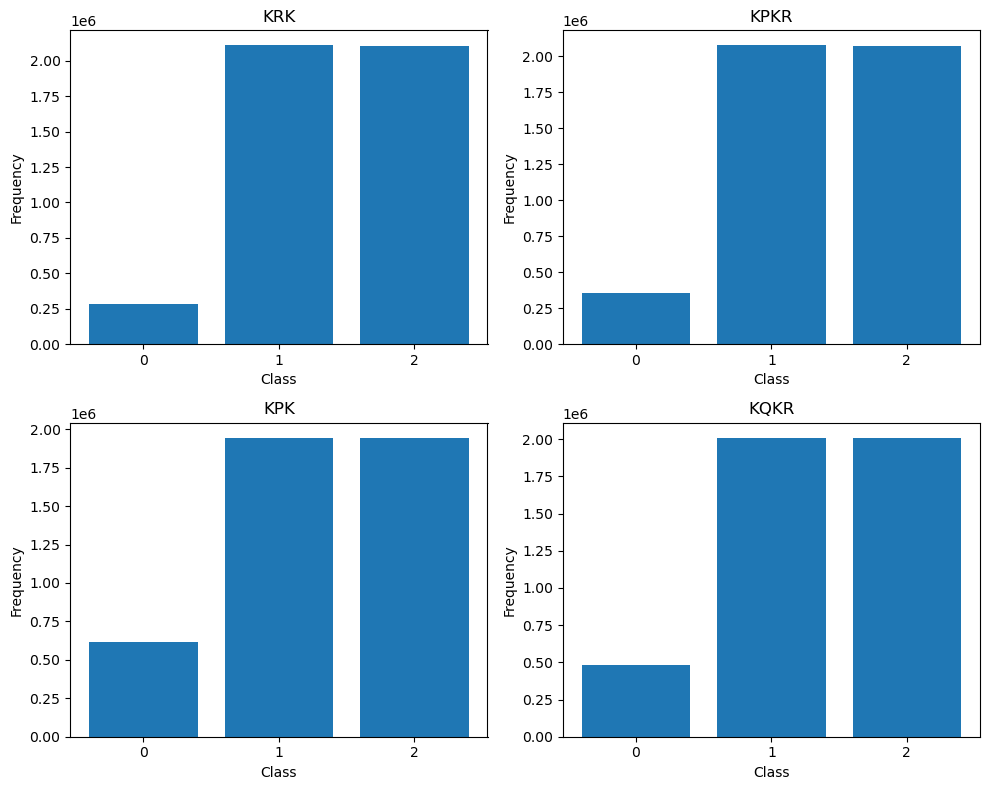

In [7]:
# Define the endgames and their additional pieces
endgames = {
    "KRK": [chess.ROOK],
    "KPKR": [chess.PAWN, chess.ROOK],
    "KPK": [chess.PAWN],
    "KQKR": [chess.QUEEN, chess.ROOK],
}

results = {}

for name, additional_pieces in endgames.items():
    print(f"\n{name}:")

    # Create, shuffle and save position data
    positions, dtm_values = create_position_data(additional_pieces)
    print(dtm_values.shape[0], "Samples generated and shuffled")

    indices = np.arange(len(dtm_values))
    np.random.shuffle(indices)
    positions = positions[indices]
    dtm_values = dtm_values[indices]

    positions_train_val, positions_test, dtm_values_train_val, dtm_values_test = train_test_split(positions, dtm_values, test_size=0.1, random_state=random_state)

    np.savez_compressed(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{name}_position_train_val_2C.npz", X=positions_train_val, y=dtm_values_train_val)
    print(f"Data saved to {name}_position_train_val_2C.npz")
    np.savez_compressed(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{name}_position_test_2C.npz", X=positions_test, y=dtm_values_test)
    print(f"Data saved to {name}_position_test_2C.npz")

    # Create, shuffle and save pairs
    X1, X2, y = create_pairs(positions, dtm_values)
    print(y.shape[0], "Pairs generated and shuffled")

    indices = np.arange(len(y))
    np.random.shuffle(indices)
    X1 = X1[indices]
    X2 = X2[indices]
    y = y[indices]

    X1_train_val, X1_test, X2_train_val, X2_test, y_train_val, y_test = train_test_split(X1, X2, y, test_size=0.1, random_state=random_state)

    np.savez_compressed(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{name}_pairs_train_val_2C.npz", X1=X1_train_val, X2=X2_train_val, y=y_train_val)
    print(f"Data saved to {name}_pairs_train_val_2C.npz")
    np.savez_compressed(fr"C:\SPEICHER\Bachelor_Thesis\Experiments\DataBase\{name}_pairs_test_2C.npz", X1=X1_test, X2=X2_test, y=y_test)
    print(f"Data saved to {name}_pairs_test_2C.npz")

    # Store counts for later plotting
    unique, counts = np.unique(y_train_val, return_counts=True)
    results[name] = (unique, counts)

n = len(results)
cols = math.ceil(math.sqrt(n))
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(10, 8))

axes = axes.flatten() if n > 1 else [axes]  # Flatten if more than one subplot

for ax, (name, (unique, counts)) in zip(axes, results.items()):
    ax.bar(unique, counts)
    ax.set_xticks(unique)
    ax.set_title(name)
    ax.set_xlabel("Class")
    ax.set_ylabel("Frequency")

# Hide unused axes if any
for i in range(len(results), len(axes)):
    axes[i].axis("off")

plt.tight_layout()
plt.show()